In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pypvcell.spectrum import Spectrum
from pypvcell.illumination import illumination,BpFilter
from pypvcell.photocurrent import calc_jsc
from pypvcell.units_system import UnitsSystem
from pypvcell.ivsolver import gen_rec_iv_with_rs_by_newton,gen_rec_iv
from pypvcell.fom import voc,isc,max_power,ff
us=UnitsSystem()

spectrum loaded!


### Show EQE of ST-1 n-type wafer

In [2]:
qe_data=np.loadtxt("/Users/kanhua/Dropbox/DDocuments/Programming projects/Python/pypvcell/examples/ms_silicon/st-1-1-1.csv",delimiter='\t')

Text(0,0.5,'EQE')

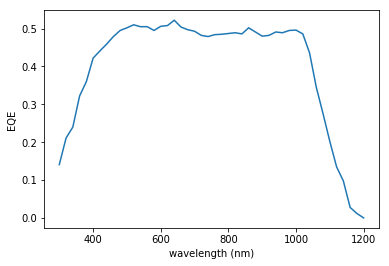

In [3]:
plt.plot(qe_data[:,0],qe_data[:,1])
plt.xlabel("wavelength (nm)")
plt.ylabel("EQE")

### Calulate photocurrents

In [4]:
eqe=Spectrum(qe_data[:,0],qe_data[:,1],x_unit="nm")
one_sun_ill=illumination()
gaas_filter=BpFilter(1.42,OD=10,f_type='low_pass')

Text(0,0.5,'Irradiance W/nm/m^2')

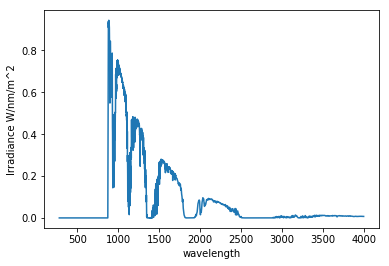

In [5]:
filtered_ill=one_sun_ill*gaas_filter
fi=filtered_ill.get_spectrum(to_x_unit='nm')
plt.plot(fi[0,:],fi[1,:])
plt.xlabel("wavelength")
plt.ylabel("Irradiance W/nm/m^2")

### Calculate Jsc from GaAs-filtered one-sun spectrum

In [6]:
jsc=calc_jsc(filtered_ill,eqe)

### Adding series resistance

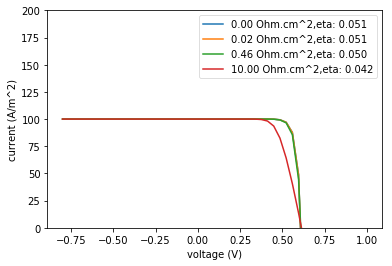

In [7]:
j01 = 5e-9
j02 = 0
n1 = 1
n2 = 2
temperature = 300
rshunt = 1e10

contact_res = np.logspace(-3, 1, num=4)

# rs=1e-10
voltage = np.linspace(-0.8, 1, num=50)

for r in contact_res:
    # rs=get_rs(r)

    rs = us.siUnits(r, 'Ohm cm^2')

    # w=us.asUnit(w,'cm')


    v, i = gen_rec_iv_with_rs_by_newton(j01, j02, n1, n2, temperature, rshunt=rshunt, rseries=rs,
                                        voltage=voltage, jsc=100, verbose=False)

    mp = max_power(v, i)
    eta=mp/1000
    #print("efficiency %s" % eta)

    plt.plot(v, -i, label="%.2f Ohm.cm^2,eta: %.3f" %(r,eta))

plt.legend()
plt.ylim([0, 200])
plt.xlabel("voltage (V)")
plt.ylabel("current (A/m^2)")

plt.savefig("si_iv.png")

The target efficiency of silicon bottom cell is 5.3%. Wiht this Voc and Jsc, it is difficult to achieve this even with zero series resistance. To achieve more than 30% III-V/Si, I recommmend the target to be at least 6%.

### Investigate the criteria for achieving more than 6%

In [23]:
jsc_range=np.linspace(95,130,num=500)
j01_range=np.logspace(-9,-6,num=500)

eta_array=np.zeros((jsc_range.shape[0],j01_range.shape[0]))
voc_array=np.zeros((j01_range.shape[0],))

for i in range(jsc_range.shape[0]):
    for j in range(j01_range.shape[0]):
        v,current=gen_rec_iv(j01_range[j],0,n1=1,n2=1,temperature=300,
                             voltage=voltage,rshunt=1e10,jsc=jsc_range[i])
        mp = max_power(v, current)
        eta=mp/1000
        eta_array[i,j]=eta
        voc_array[j]=voc(v,current)

<a list of 6 text.Text objects>

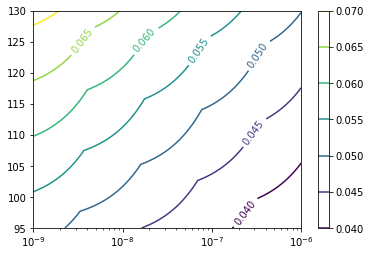

In [24]:
cs=plt.contour(j01_range,jsc_range,eta_array)
plt.xscale("log")
plt.colorbar()
plt.clabel(cs)

<a list of 6 text.Text objects>

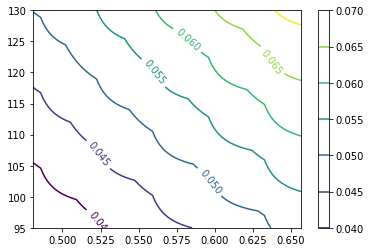

In [25]:
cs=plt.contour(voc_array,jsc_range,eta_array)
plt.xscale("linear")
plt.colorbar()
plt.clabel(cs)

In [ ]:
def lump_r(sw, sl, fw, fh, rho_c, rho_f, rho_sh, N):
    w = sw / N

    pitch = w - fw  # pitch between fingers

    # print("pitch:%s"%pitch)

    Rc = rho_c / (fw * sl)

    Rf = 2* rho_f * (sl / 3) / (fw * fh)

    Rsh = 2 * rho_sh * (sw / 2)

    R_lump = Rc + Rf + Rsh

    return R_lump, R_lump * w * sl

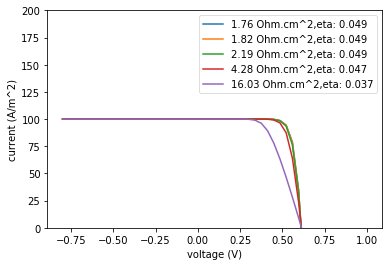

In [34]:


j01 = 5e-9
j02 = 0
n1 = 1
n2 = 2
temperature = 300
rshunt = 1e10

#contact_res = np.logspace(-3, 1, num=4)

contact_res=np.logspace(0,3,num=5)

# rs=1e-10
voltage = np.linspace(-0.8, 1, num=50)

for r in contact_res:

    #rs = us.siUnits(r, 'Ohm cm^2')

    
    lr, rs = lump_r(us.siUnits(1, "cm"), us.siUnits(1, "cm"),
                   us.siUnits(100, 'um'), us.siUnits(100, 'nm'),
                   us.siUnits(r, "mOhm cm2"), us.siUnits(2.44e-8, "Ohm m"),
                   rho_sh=us.siUnits(0.0001, "Ohm"), N=7)
    
    
    v, i = gen_rec_iv_with_rs_by_newton(j01, j02, n1, n2, temperature, rshunt=rshunt, rseries=rs,
                                        voltage=voltage, jsc=100, verbose=False)

    mp = max_power(v, i)
    eta=mp/1000
    #print("efficiency %s" % eta)

    plt.plot(v, -i, label="%.2f Ohm.cm^2,eta: %.3f" %(us.asUnit(rs,"Ohm cm^2"),eta))

plt.legend()
plt.ylim([0, 200])
plt.xlabel("voltage (V)")
plt.ylabel("current (A/m^2)")

plt.savefig("si_iv.png")